In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
    
# make cudnn deterministic
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Read dataset from file (Dataset-English_to_French.txt)
with open("Dataset-English_to_French.txt", "r", encoding="utf-8") as f:
    data_str = f.read()
exec(data_str)  # This defines english_to_french

# Create reversed dataset: French-to-English
french_to_english = [(fr, eng) for (eng, fr) in english_to_french]

# Build word-level vocabulary from both French and English sentences
all_words = []
for fr, eng in french_to_english:
    all_words.extend(fr.split())
    all_words.extend(eng.split())
vocab = sorted(list(set(all_words)))
# Define special tokens: SOS (start) and EOS (end)
SOS_token = 0
EOS_token = 1
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for i, word in enumerate(vocab):
    word_to_index[word] = i + 2
index_to_word = {i: word for word, i in word_to_index.items()}

print("Vocabulary size:", len(word_to_index))
print("\nSample data from french_to_english:")
for i, sample in enumerate(french_to_english[:5]):
    print(f"Sample {i+1}: {sample}")

Vocabulary size: 511

Sample data from french_to_english:
Sample 1: ("J'ai froid", 'I am cold')
Sample 2: ('Tu es fatigué', 'You are tired')
Sample 3: ('Il a faim', 'He is hungry')
Sample 4: ('Elle est heureuse', 'She is happy')
Sample 5: ('Nous sommes amis', 'We are friends')


In [3]:
# Create a custom Dataset for French-to-English translation (word-based)
class TranslationDataset(Dataset):
    """Custom Dataset for French-to-English translation (word-based)."""
    def __init__(self, data, word_to_index):
        self.data = data  # Here data is french_to_english
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fr, eng = self.data[idx]  # Note: input is French, target is English
        # Tokenize by splitting on whitespace and append EOS token
        input_tensor = torch.tensor([self.word_to_index[word] for word in fr.split()] + [EOS_token], dtype=torch.long)
        target_tensor = torch.tensor([self.word_to_index[word] for word in eng.split()] + [EOS_token], dtype=torch.long)
        return input_tensor, target_tensor

# Instantiate the dataset and dataloader
dataset = TranslationDataset(french_to_english, word_to_index)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [4]:
# Define the GRU-based Encoder (word-based)
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Embed input token and reshape for GRU (sequence length = 1)
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Define the GRU-based Decoder (word-based)
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Instantiate models with word-level vocabulary size
input_size = len(word_to_index)
hidden_size = 256
output_size = len(word_to_index)

encoder = EncoderGRU(input_size, hidden_size).to(device)
decoder = DecoderGRU(hidden_size, output_size).to(device)

In [5]:
# Training function for one sample pair (word-based)
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    input_tensor = input_tensor.squeeze(0)
    target_tensor = target_tensor.squeeze(0)
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
        
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    predicted_indices = []
    
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        topv, topi = decoder_output.topk(1)
        predicted_indices.append(topi.item())
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token:
            break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length, predicted_indices

def evaluate_model(encoder, decoder, dataloader, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    total_samples = 0
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.squeeze(0).to(device)
            target_tensor = target_tensor.squeeze(0).to(device)
            
            encoder_hidden = encoder.initHidden()
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            loss = 0
            predicted_indices = []
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
            decoder_input = torch.tensor([SOS_token], device=device)
            decoder_hidden = encoder_hidden
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
                topv, topi = decoder_output.topk(1)
                predicted_indices.append(topi.item())
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == EOS_token:
                    break
            total_loss += loss.item() / target_length
            correct = 0
            for i in range(target_length):
                if i < len(predicted_indices) and predicted_indices[i] == target_tensor[i].item():
                    correct += 1
            total_correct += correct
            total_tokens += target_length
            total_samples += 1
    avg_loss = total_loss / total_samples
    token_accuracy = total_correct / total_tokens
    return avg_loss, token_accuracy

In [6]:
# Set up optimizers and loss function
learning_rate = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

n_epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    total_loss = 0
    encoder.train()
    decoder.train()
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        loss, _ = train(input_tensor, target_tensor, encoder, decoder,
                        encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss
    avg_train_loss = total_loss / len(dataloader)
    train_losses.append(avg_train_loss)
    
    val_loss, val_accuracy = evaluate_model(encoder, decoder, dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Token Accuracy: {val_accuracy:.4f}')

Epoch 1, Train Loss: 3.7292, Val Loss: 3.3851, Token Accuracy: 0.0972
Epoch 2, Train Loss: 3.3536, Val Loss: 2.4818, Token Accuracy: 0.0643
Epoch 3, Train Loss: 3.4262, Val Loss: 3.2895, Token Accuracy: 0.0956
Epoch 4, Train Loss: 3.3945, Val Loss: 3.0849, Token Accuracy: 0.0906
Epoch 5, Train Loss: 3.3610, Val Loss: 2.9381, Token Accuracy: 0.0972
Epoch 6, Train Loss: 3.3450, Val Loss: 2.9456, Token Accuracy: 0.1549
Epoch 7, Train Loss: 3.1316, Val Loss: 2.7516, Token Accuracy: 0.1565
Epoch 8, Train Loss: 3.0122, Val Loss: 2.8560, Token Accuracy: 0.2405
Epoch 9, Train Loss: 2.9741, Val Loss: 2.9534, Token Accuracy: 0.3344
Epoch 10, Train Loss: 2.8649, Val Loss: 2.4938, Token Accuracy: 0.3048
Epoch 11, Train Loss: 2.7195, Val Loss: 2.2661, Token Accuracy: 0.2867
Epoch 12, Train Loss: 2.5361, Val Loss: 2.2540, Token Accuracy: 0.3575
Epoch 13, Train Loss: 2.4591, Val Loss: 2.1469, Token Accuracy: 0.3723
Epoch 14, Train Loss: 2.2421, Val Loss: 2.0765, Token Accuracy: 0.4135
Epoch 15, Train

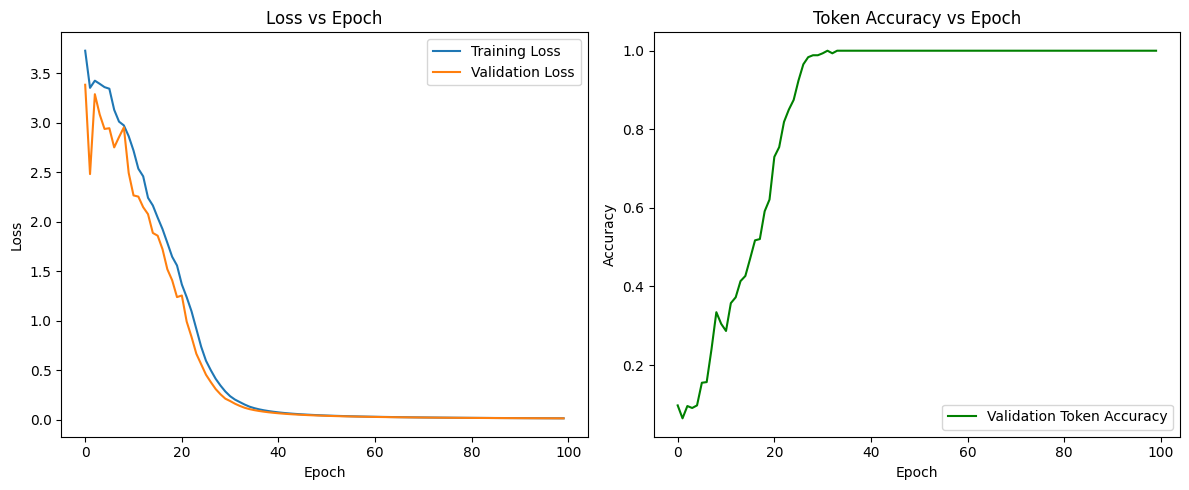

In [7]:
# Plot loss and accuracy curves
epochs = range(n_epochs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Token Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Token Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('images/p3_GRU_fte_output.png')
plt.show()

In [8]:
# Output some sample translations: original, target, and predicted (for French-to-English)
encoder.eval()
decoder.eval()
num_examples = 5

print("\nSample Translations (French-to-English):")
sample_count = 0
with torch.no_grad():
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.squeeze(0).to(device)
        target_tensor = target_tensor.squeeze(0).to(device)
        
        encoder_hidden = encoder.initHidden()
        input_length = input_tensor.size(0)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
        
        decoder_input = torch.tensor([SOS_token], device=device)
        decoder_hidden = encoder_hidden
        predicted_indices = []
        while True:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            predicted_indices.append(topi.item())
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token or len(predicted_indices) > 50:
                break
        
        original_sentence = " ".join([index_to_word[idx.item()] for idx in input_tensor if idx.item() not in [SOS_token, EOS_token]])
        target_sentence = " ".join([index_to_word[idx.item()] for idx in target_tensor if idx.item() not in [SOS_token, EOS_token]])
        predicted_sentence = " ".join([index_to_word[idx] for idx in predicted_indices if idx not in [SOS_token, EOS_token]])
        
        print("Input (French):", original_sentence)
        print("Target (English):", target_sentence)
        print("Predicted (English):", predicted_sentence)
        print("-" * 50)
        
        sample_count += 1
        if sample_count >= num_examples:
            break


Sample Translations (French-to-English):
Input (French): Il vérifie ses emails
Target (English): He checks his email
Predicted (English): He checks his email
--------------------------------------------------
Input (French): Le professeur explique la leçon
Target (English): The teacher explains the lesson
Predicted (English): The teacher explains the lesson
--------------------------------------------------
Input (French): Le chien aboie bruyamment
Target (English): The dog barks loudly
Predicted (English): The dog barks loudly
--------------------------------------------------
Input (French): Le bébé dort paisiblement
Target (English): The baby sleeps peacefully
Predicted (English): The baby sleeps peacefully
--------------------------------------------------
Input (French): Nous plantons des fleurs dans le jardin
Target (English): We plant flowers in the garden
Predicted (English): We plant flowers in the garden
--------------------------------------------------
